In [1]:
import numpy as np
from netCDF4 import Dataset, num2date

import matplotlib
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import matplotlib.colors as colors
import matplotlib.image as image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
import cartopy.crs as ccrs
import string
import datetime as dt
import cftime as cf

from scipy import stats

%matplotlib inline

In [2]:
#slopeDS = Dataset('/scratch/srai6/EddyKillingPaper3/QuikSCAT/100kmResults/slopeAndCorr2D_0100km.nc')
#slope2d = np.array(slopeDS.variables['slope'][:,:])
slope2d = 1 #1/2.578 #1/2.729

In [4]:
fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/run/'
ell = 50

gridFile = 'input/ROMSgrid.nc'
maskFile = 'input/landMask.nc'
keMaskFile = 'input/mask.nc'

rotFile = 'output/{0:d}km/1to200/NLMonPosAndNegVort_0050km.nc'.format(ell)
strFile = 'output/{0:d}km/1to200/NLMon45degAndMinus45degStrain_0050km.nc'.format(ell)

grid_ds = Dataset(fldLoc + gridFile)
mask_ds = Dataset(fldLoc + keMaskFile)
rot_ds = Dataset(fldLoc + rotFile)
str_ds = Dataset(fldLoc + strFile)
kmtDS = Dataset(fldLoc + maskFile)

In [5]:
mask_ds.variables.keys()

dict_keys(['highKEandEKEmask'])

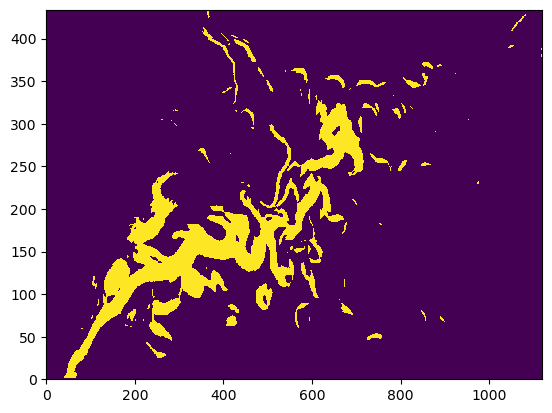

In [6]:
posThetaNLMstr = np.array(str_ds.variables['posThetaNLMstr'])/slope2d
negThetaNLMstr = np.array(str_ds.variables['negThetaNLMstr'])/slope2d
posVortNLMrot = np.array(rot_ds.variables['posVortNLMrot'])/slope2d
negVortNLMrot = np.array(rot_ds.variables['negVortNLMrot'])/slope2d

UAREA = np.array(grid_ds.variables['UAREA'])
ULAT = np.array(grid_ds.variables['ULAT'])
ULONG = np.array(grid_ds.variables['ULONG'])
#KMT = np.array(grid_ds.variables['KMT'])
landMask = np.array(kmtDS.variables['landMask'][:,:], dtype=bool)
highKE_mask = np.array(mask_ds.variables['highKEandEKEmask'][:,:], dtype=bool)

highKE_sumArea = np.sum(UAREA[highKE_mask])

plt.pcolormesh(highKE_mask)

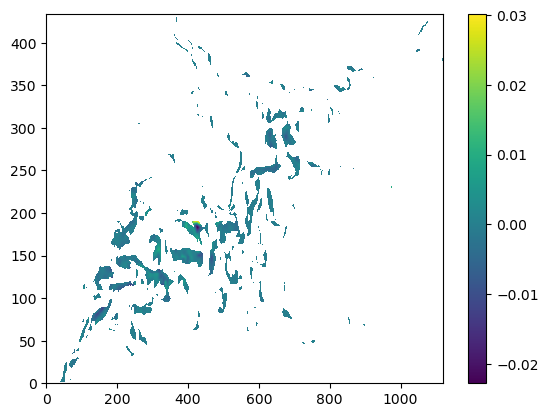

In [7]:
posThetaNLMstr_highKE = posThetaNLMstr.copy() 
negThetaNLMstr_highKE = posThetaNLMstr.copy() 
posVortNLMrot_highKE = posThetaNLMstr.copy() 
negVortNLMrot_highKE = posThetaNLMstr.copy() 

posThetaNLMstr_highKE[:,~highKE_mask] = float('nan')
negThetaNLMstr_highKE[:,~highKE_mask] = float('nan')
posVortNLMrot_highKE[:,~highKE_mask] = float('nan')
negVortNLMrot_highKE[:,~highKE_mask] = float('nan')

plt.pcolormesh(posThetaNLMstr_highKE[0,:,:])
plt.colorbar()

posThetaNLMstr_highKE_TS = np.nansum( posThetaNLMstr_highKE*UAREA, axis=(1,2))/highKE_sumArea
negThetaNLMstr_highKE_TS = np.nansum( negThetaNLMstr_highKE*UAREA, axis=(1,2))/highKE_sumArea
posVortNLMrot_highKE_TS = np.nansum( posVortNLMrot_highKE*UAREA, axis=(1,2))/highKE_sumArea
negVortNLMrot_highKE_TS = np.nansum( negVortNLMrot_highKE*UAREA, axis=(1,2))/highKE_sumArea

del posThetaNLMstr_highKE, negThetaNLMstr_highKE, posVortNLMrot_highKE, negVortNLMrot_highKE

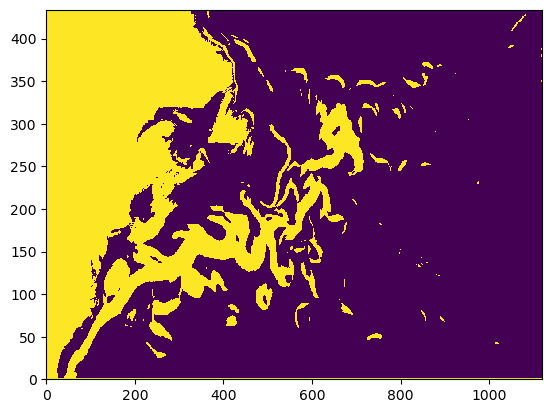

In [8]:
landMaskWithHiKE = np.logical_or(landMask, highKE_mask)
plt.pcolormesh(landMaskWithHiKE)

In [9]:
posThetaNLMstr[:, landMaskWithHiKE ] = float('nan')  
negThetaNLMstr[:, landMaskWithHiKE ] = float('nan')  
posVortNLMrot[:, landMaskWithHiKE ] = float('nan')  
negVortNLMrot[:, landMaskWithHiKE ] = float('nan')  
UAREA [landMaskWithHiKE] = float('nan')

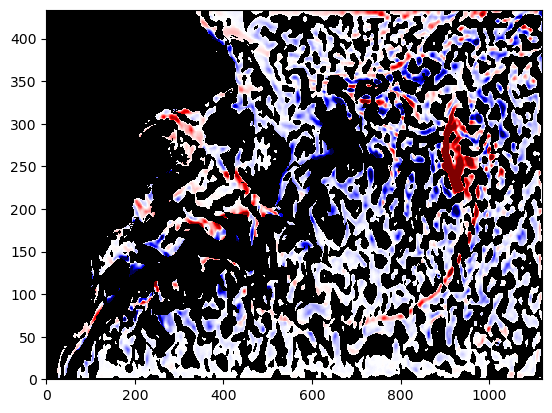

In [10]:
cmap_seismic = plt.get_cmap('seismic')
cmap_seismic.set_bad('k')
plt.pcolormesh(posVortNLMrot[0,:,:], vmin=-5e-3, vmax=5e-3, cmap=cmap_seismic)
#plt.contour(mask_5S_5N)

In [11]:
mask = ~landMaskWithHiKE
maskedArea =  np.nansum(UAREA[mask])
posThetaNLMstr_lowKE_TS = np.nansum(posThetaNLMstr[:,mask] * UAREA[mask], axis = (1))/maskedArea 
negThetaNLMstr_lowKE_TS = np.nansum(negThetaNLMstr[:,mask] * UAREA[mask], axis = (1))/maskedArea 
posVortNLMrot_lowKE_TS = np.nansum(posVortNLMrot[:,mask] * UAREA[mask], axis = (1))/maskedArea 
negVortNLMrot_lowKE_TS = np.nansum(negVortNLMrot[:,mask] * UAREA[mask], axis = (1))/maskedArea 

In [12]:
ksize = 8
half_ksize = ksize//2
kernel = np.ones((ksize,), dtype=float)/ksize

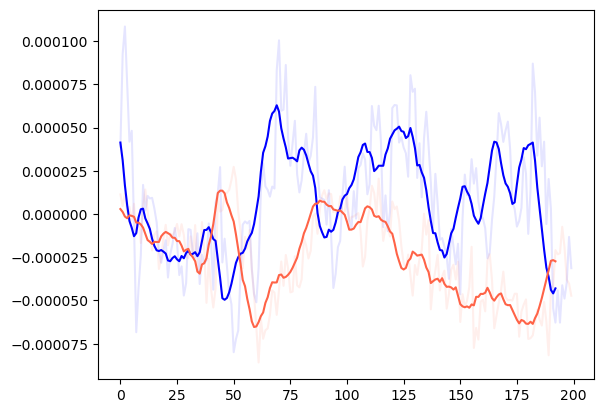

In [13]:
plt.plot(posVortNLMrot_lowKE_TS, color='blue', alpha=0.1)
plt.plot(negVortNLMrot_lowKE_TS, color='tomato', alpha=0.1)
plt.plot(np.convolve(posVortNLMrot_lowKE_TS, kernel, mode='valid'), color='blue')
plt.plot(np.convolve(negVortNLMrot_lowKE_TS, kernel, mode='valid'), color='tomato')
vortArr_lowKE_TS = np.stack((posVortNLMrot_lowKE_TS, negVortNLMrot_lowKE_TS), axis = 0)

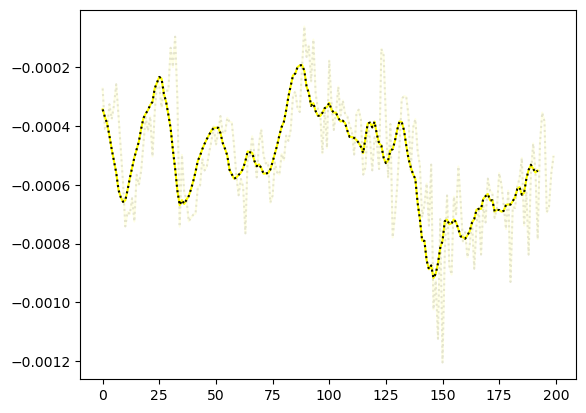

In [14]:
plt.plot(negVortNLMrot_highKE_TS, color='yellow', alpha=0.1)
plt.plot(posVortNLMrot_highKE_TS, color='black', linestyle = ':', alpha=0.1)
plt.plot(np.convolve(negVortNLMrot_highKE_TS, kernel, mode='valid'), color='yellow')
plt.plot(np.convolve(posVortNLMrot_highKE_TS, kernel, mode='valid'), color='black',linestyle = ':')
vortArr_highKE_TS = np.stack((posVortNLMrot_highKE_TS, negVortNLMrot_highKE_TS), axis = 0)

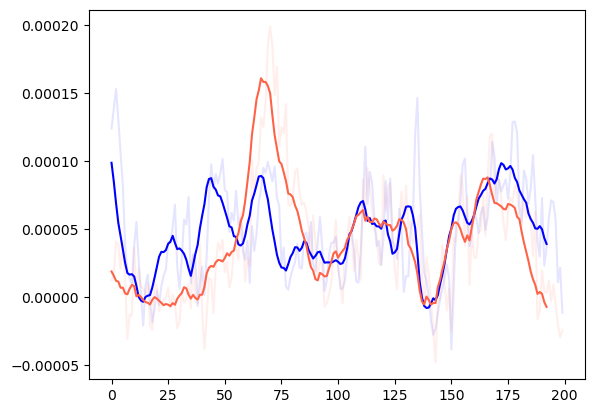

In [15]:
plt.plot(posThetaNLMstr_lowKE_TS, color='blue', alpha=0.1)
plt.plot(negThetaNLMstr_lowKE_TS, color='tomato', alpha=0.1)
plt.plot(np.convolve(posThetaNLMstr_lowKE_TS, kernel, mode='valid'), color='blue')
plt.plot(np.convolve(negThetaNLMstr_lowKE_TS, kernel, mode='valid'), color='tomato')
thetaArr_lowKE_TS = np.stack((posThetaNLMstr_lowKE_TS, negThetaNLMstr_lowKE_TS), axis = 0)

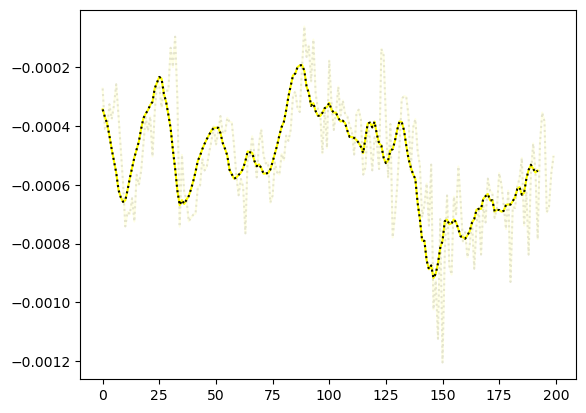

In [16]:
plt.plot(negThetaNLMstr_highKE_TS, color='yellow', alpha=0.1)
plt.plot(posThetaNLMstr_highKE_TS, color='black', linestyle = ':', alpha=0.1)
plt.plot(np.convolve(negThetaNLMstr_highKE_TS, kernel, mode='valid'), color='yellow')
plt.plot(np.convolve(posThetaNLMstr_highKE_TS, kernel, mode='valid'), color='black',linestyle = ':')
thetaArr_highKE_TS = np.stack((posThetaNLMstr_highKE_TS, negThetaNLMstr_highKE_TS), axis = 0)

In [17]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import matplotlib
import matplotlib.dates as mdates
import string
import datetime as dt
import cftime as cf

from scipy import stats

%matplotlib inline

In [18]:
dateUnits = 'hours since 2000-01-01 00:00:00'

ndays = 200

cfdates = num2date(3 * (np.arange(ndays)), dateUnits)
#strdates = ['{0:02d}/{1:02d}/{2:04d} {3:02d}:{4:02d}'.format(d.month, d.day, d.year, d.hour, d.minute) for d in cfdates]
dates = [dt.datetime(d.year,d.month, d.day, d.hour, d.minute ) for d in cfdates]

years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator(interval =4)  # every 4 month
months = mdates.MonthLocator(bymonth = (4,7,10))
#months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%b')

date_fmt = mdates.DateFormatter('%b %Y %h %m')


PlotTitle = {'Gulf': 'Gulf Stream',
             'Kuroshio': 'Kuroshio Extension',
             'BrazilACC': 'Brazil Malvinas',
             'Agulhas': 'Agulhas',
             'ACC': 'ACC',
             'Equator': 'Equator',
             'SouthernOcean': 'Southern Ocean',
             'Global': 'Global'}


In [19]:
dt.datetime(2000,8,30,13,58)

datetime.datetime(2000, 8, 30, 13, 58)

In [20]:
def getRunAvg(array1D, ksize):
    ndays = len(array1D)
    
    ksize = 8
    half_ksize = ksize//2
    kernel = np.ones((ksize,), dtype=float)/ksize
    

    runAvg = np.convolve(array1D, kernel, mode='valid')
    lastindx = half_ksize+len(runAvg)
    
    plt_runAvg = np.ones((ndays), dtype =float) * float('nan')
    plt_runAvg[half_ksize:lastindx] = runAvg
    
    return plt_runAvg

def getCorrCoeffWithStdErr(arr1, arr2):
    coeff= np.corrcoef(arr1, arr2)[0, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(arr1, arr2)
    stdev_arr1 = np.std(arr1)
    stdev_arr2 = np.std(arr2)
    prob = 0.95
    Npoints = len(arr1)
    t_star = stats.t.cdf( 1 - (1-prob)/2, Npoints - 1 )
    std_err *= t_star *stdev_arr1/stdev_arr2
    return coeff, std_err
    
def plot_Trend(dates, array1DList, labelList, title, ax, showXticks=True):
    ndays = len(dates)
    
    narrs = len(array1DList)
    txt = '{0:s}\n'.format(title)
    
    pltArr = np.zeros((narrs, ndays), dtype =float)
    
    for i in range(narrs):
        pltArr[i,:] = getRunAvg(array1DList[i], 13)
        
    for i in range(1,narrs):
        r, stderr = getCorrCoeffWithStdErr(pltArr[0,:][~np.isnan(pltArr[0,:])], 
                                           pltArr[i,:][~np.isnan(pltArr[i,:])])
        if narrs<=2:
            txt += r'r = {0:>5.2f}$\pm${1:>4.2f}'.format(r, stderr)
        else:
            txt += r'r{0:d} = {1:>5.2f}$\pm${2:>4.2f}'.format(i,r, stderr)
    
    maxVals = []
    minVals = []
    for i in range(narrs):
        maxVals.append(np.nanmax(pltArr[i,:]))
        minVals.append(np.nanmin(pltArr[i,:]))
        ax.plot(dates, 
                pltArr[i,:], 
                rasterized = True, 
                label=labelList[i])
      
    
    maxy = max(maxVals)
    miny = min(minVals)
    
    diffy = maxy-miny

    ax.set_ylim([miny - 0.08 * diffy, (maxy + 0.5 * diffy)])

    ax.grid(visible=True, which='major', axis='both', linewidth=0.5, alpha = 0.5)
    ax.grid(visible=True, which='minor', axis='x', linewidth=0.1, alpha=0.2)
    
    #ax.xaxis.set_major_locator(years)
    #ax.xaxis.set_major_formatter(date_fmt)
    
    #plt.setp(ax.yaxis.get_majorticklabels(), size=15)
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, size=15)
    
    if showXticks==False:
        plt.setp(ax.get_xticklabels(), visible=False)
      
    ax.text(0.01, 1, txt, horizontalalignment='left', fontweight = 'heavy', 
                    verticalalignment='top', transform=ax.transAxes, fontsize=17)
    
    ax.legend(ncol = 2 , loc="upper right", fontsize = 14)


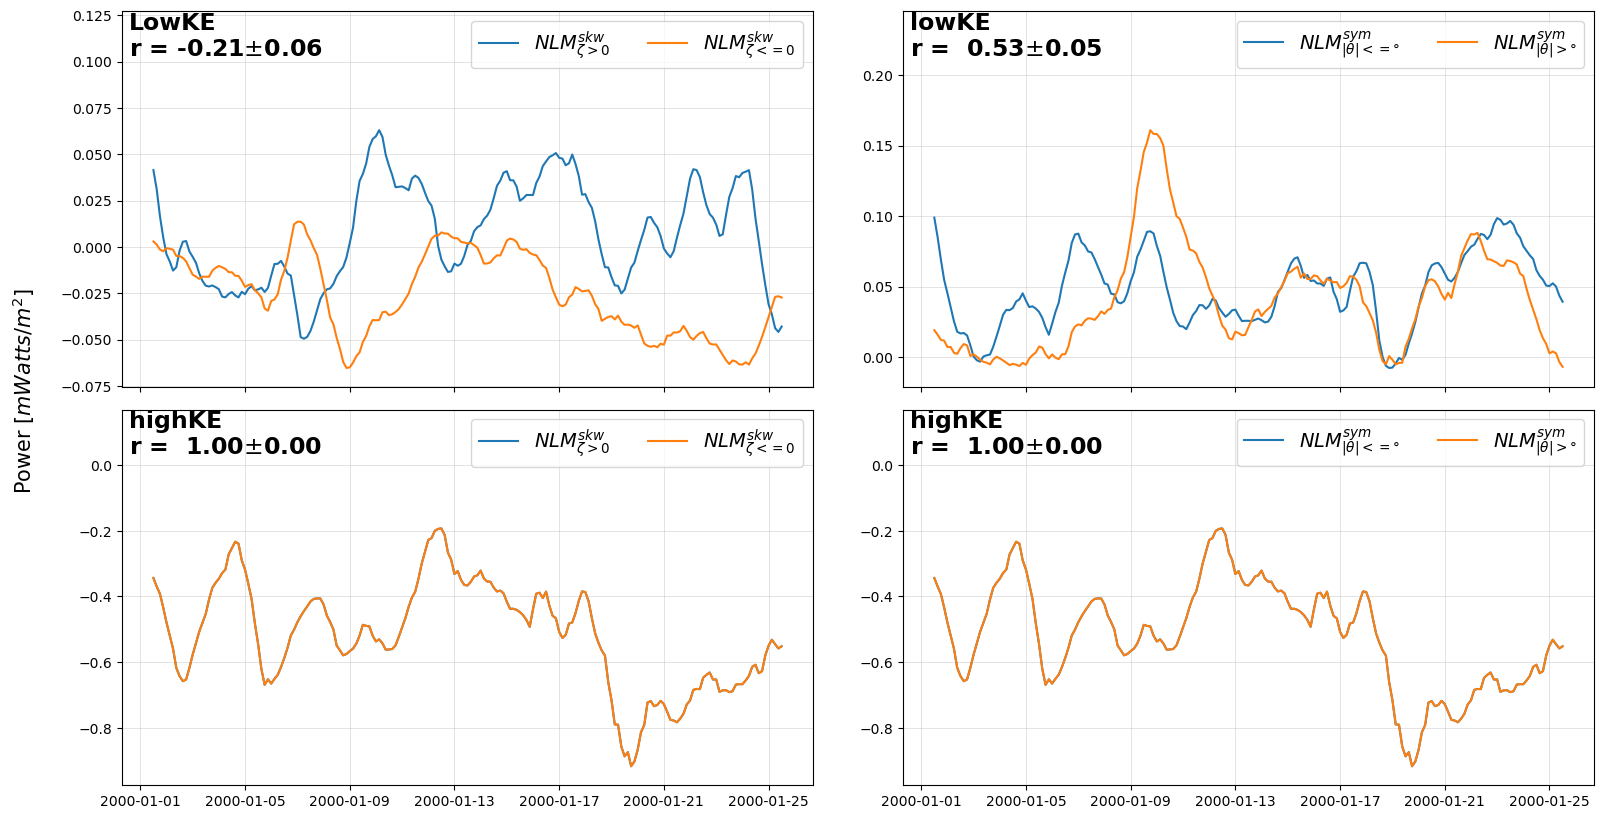

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (16, 9 ), sharex =True)
plot_Trend(dates, vortArr_lowKE_TS*1e3, [r'$NLM^{skw}_{\zeta>0}$',r'$NLM^{skw}_{\zeta<=0}$'], 'LowKE', ax[0,0] )

plot_Trend(dates, vortArr_highKE_TS*1e3, [r'$NLM^{skw}_{\zeta>0}$',r'$NLM^{skw}_{\zeta<=0}$'], 'highKE', ax[1,0] )

plot_Trend(dates, thetaArr_lowKE_TS*1e3, [r'$NLM^{sym}_{|\theta|<=\degree}$',r'$NLM^{sym}_{|\theta|>\degree}$'], 'lowKE', ax[0,1] )

plot_Trend(dates, thetaArr_highKE_TS*1e3, [r'$NLM^{sym}_{|\theta|<=\degree}$',r'$NLM^{sym}_{|\theta|>\degree}$'], 'highKE', ax[1,1] )


fig.text(0.00, 0.45, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15,rasterized=True)
plt.subplots_adjust(hspace = 0.06, wspace = 0.13, left = 0.07, right = 0.99, bottom = 0.12, top = 0.98 )
#plt.savefig('NLM_orientationTimeSeries.pdf', dpi=70)

In [24]:
slope2d = 1#1/2.578 #2.729

UAREA = np.array(grid_ds.variables['UAREA'])
ULAT = np.array(grid_ds.variables['ULAT'])
ULONG = np.array(grid_ds.variables['ULONG'])
# KMT = np.array(grid_ds.variables['KMT'])
# landMask = KMT < 1 


ds_rot = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/output/{0:d}km/1to200/avgNLMonPosAndNegVort_0050km.nc'.format(ell))
print(ds_rot.variables.keys())

ds_str = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/output/{0:d}km/1to200/avgNLMon45degAndMinus45degStrain_0050km.nc'.format(ell))
print(ds_str.variables.keys())

posVortNLMrot = np.array(ds_rot.variables['posVortNLMrot'][:,:])/slope2d
negVortNLMrot = np.array(ds_rot.variables['negVortNLMrot'][:,:])/slope2d
posThetaNLMstr = np.array(ds_str.variables['posThetaNLMstr'][:,:])/slope2d
negThetaNLMstr = np.array(ds_str.variables['negThetaNLMstr'][:,:])/slope2d


posVortNLMrot[landMask] = float('nan')
negVortNLMrot[landMask] = float('nan')
posThetaNLMstr[landMask] = float('nan')
negThetaNLMstr[landMask] = float('nan')

posVortNLMrot_AreaInt = posVortNLMrot * UAREA
negVortNLMrot_AreaInt = negVortNLMrot * UAREA
posThetaNLMstr_AreaInt = posThetaNLMstr * UAREA
negThetaNLMstr_AreaInt = negThetaNLMstr * UAREA


ds_okuboweiss = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/output/{0:d}km/1to200/tavgOkuboWeissAndStrainDirec_0050km_AllDay.nc'.format(ell))
print(ds_okuboweiss.variables.keys())

theta1_tau =np.array(ds_okuboweiss.variables['theta1_tau'][0,:,:])
theta1_tau[landMask] = float('nan')

theta2_tau =np.array(ds_okuboweiss.variables['theta2_tau'][0,:,:])
theta2_tau[landMask] = float('nan')

eig1_tau =np.array(ds_okuboweiss.variables['eig1_tau'][0,:,:])
eig1_tau[landMask] = float('nan')

eig2_tau =np.array(ds_okuboweiss.variables['eig2_tau'][0,:,:])
eig2_tau[landMask] = float('nan')

curl_stress =np.array(ds_okuboweiss.variables['curl_stress'][0,:,:])
curl_stress[landMask] = float('nan')


dict_keys(['posVortNLMrot', 'negVortNLMrot', 'posVortNLMrot_AreaInt', 'negVortNLMrot_AreaInt'])
dict_keys(['posThetaNLMstr', 'negThetaNLMstr', 'posThetaNLMstr_AreaInt', 'negThetaNLMstr_AreaInt'])
dict_keys(['time', 'okuboWeiss_vel', 'eig1_tau', 'eig2_tau', 'theta1_tau', 'theta2_tau', 'eig1_vel', 'eig2_vel', 'theta1_vel', 'theta2_vel', 'curl_stress', 'vorticity'])


In [25]:
def plot2D_clim(plotMat, X, Y, 
                textInFig, 
                lim, 
                cbUnits, 
                ax, figLabel, 
                cf = True,
                figLabelColor = 'white', 
                textInFigColor = 'white',
                cmapName=cmap_seismic,
                greaterThan = True,
                lessThan = True,
                topXlabel = True,
                botXlabel = True,
                leftYlabel = True,
                rightYlabel = True,
                writeColorBar = False,
                returnPlot = False,
                projection = False):
    minval = np.nanmin(plotMat)
    maxval = np.nanmax(plotMat)

    print(minval)
    print(maxval)

    if abs(minval) < maxval:
        val = abs(minval) * 0.1
    else:
        val = abs(maxval) * 0.1
        
    cmap = plt.get_cmap(cmapName).copy()
    levels = 150
    level_boundaries = np.linspace(-lim, lim, levels)
    norm = mpl.colors.BoundaryNorm(level_boundaries, cmap.N)
    
    extd = 'neither'
    if greaterThan and lessThan:
        extd = 'both'
    elif greaterThan:
            extd = 'min'
    elif lessThan:
            extd = 'max'
            
    if cf:        
        pmesh = ax.contourf(X, Y, plotMat, levels = level_boundaries, cmap=cmap, norm = norm, extend=extd,
                            rasterized=True, vmin = -lim, vmax = lim)
    else:
        pmesh = ax.pcolormesh(X, Y, plotMat,  cmap=cmap,
                        rasterized=True, vmin = -lim, vmax = lim)
    
#     ax.tick_params(which='both', size=4, labelsize=15)
#     ax.set_xlabel(r'$^\circ$E', fontsize=15)
#     ax.set_ylabel(r'$^\circ$N', fontsize=15, rotation=0)
#     ax.xaxis.set_label_coords(1.02,-0.01)
#     ax.yaxis.set_label_coords(-0.01,1.02)
    
    if writeColorBar:
        #setting colorbar ticks
        exp = int(np.log10(lim))
        if exp < 0: exp-=1
        # if exp > 0: exp+=1
    #     print('lim=', lim)
    #     print('ext=', exp)

        dlim = 2*lim/8
        tickList = list(np.arange(-lim, lim+dlim, dlim))
        cb = plt.colorbar(pmesh, ax=ax, ticks=tickList, extend = extd)

        strTickList = ['{0:04.2f}'.format(x) for x in tickList]

        if greaterThan:
            strTickList[0] = '$<$' + strTickList[0]
        if lessThan:
            strTickList[-1] = '$>$' + strTickList[-1]

        cb.ax.set_yticklabels(strTickList)

        #cbTitle = r'({0})$\times 10^{1}$'.format(cbUnits, '{'+str(exp)+'}' )

        cbTitle = r'{0}'.format(cbUnits)

        cb.ax.set_title(cbTitle, size=15, pad = 24) #pad is in points
        cb.ax.tick_params(labelsize=15)
    
    xpos, ypos = 0.60, 0.93
    t1 = ax.text(xpos, ypos, textInFig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize = 15, weight='heavy', color=textInFigColor)
    t1.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))
        
    xpos, ypos = 0.20, 0.93
    t2 = ax.text(xpos, ypos, figLabel, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize = 18, weight='heavy', color=figLabelColor)
    
    t2.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))
    
    if projection:
        ax.projection = ccrs.PlateCarree(central_longitude=180)
        ax.coastlines()
        ax.background_patch.set_facecolor('silver')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='gray', alpha=0.0, linestyle='--')
        xlen = len(X)
        gl.xlocator = mplticker.FixedLocator(list(np.arange(-180,180,60)))
        gl.ylocator = mplticker.FixedLocator(list(np.arange(-90,90,30)))
        
        if topXlabel:
            gl.top_labels = True
        else:
            gl.top_labels = False
            
        if botXlabel:
            gl.bottom_labels = True
        else:
            gl.bottom_labels = False
            
        if leftYlabel:
            gl.left_labels = True
        else:
            gl.left_labels = False
            
        if rightYlabel:
            gl.right_labels = True
        else:
            gl.right_labels = False
            
    
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
        ax.set_aspect('auto')
    
    if returnPlot:
        return pmesh
    

In [26]:
def showCommonColorbar(pmesh, cax, lim, cbUnits, 
                       greaterThan = True, lessThan = True,
                       orientation = 'vertical',
                       labelFormat = 'float',
                       aspect = 30, fraction = 1, padding = 25,
                       anchor = (0,0)):
    
    exp = int(np.log10(lim))
    if exp < 0: exp-=1    
    dlim = 2*lim/8
    tickList = list(np.arange(-lim, lim+dlim, dlim))

    if labelFormat == 'float':
        strTickList = ['{0:04.2f}'.format(x) for x in tickList]
    else:
        strTickList = ['{0:2.0f}'.format(x) for x in tickList]
    extd = 'neither'
    
    if greaterThan and lessThan:
        extd = 'both'
    elif greaterThan:
            extd = 'min'
    elif lessThan:
            extd = 'max'

    if greaterThan:
        strTickList[0] = '$<$' + strTickList[0]
    if lessThan:
        strTickList[-1] = '$>$' + strTickList[-1]
        
    cb = fig.colorbar(pmesh, cax = cax,
                      #ax=axList.ravel().tolist(), 
                      ticks=tickList, extend = extd, 
                      orientation = orientation)#,
                      #aspect = aspect, fraction = fraction, pad = pad,
                      #anchor = anchor)
    #cb = plt.colorbar(pmesh, ax=ax, ticks=tickList)
    #cbTitle = r'({0})$\times 10^{1}$'.format(cbUnits, '{'+str(exp)+'}' )   
    
    cbTitle = r'{0}'.format(cbUnits) 
    if orientation == 'vertical':
        cb.ax.set_yticklabels(strTickList)
        cb.ax.set_title(cbTitle, size=15, pad=padding)
    else:
        cb.ax.set_xticklabels(strTickList)
        cb.set_label(cbTitle, labelpad=-1, size=15)
    cb.ax.tick_params(labelsize=15)

-12.708543064058063
1.9224581478085976
-10.013362941570923
1.6721153853005073
-8.438769412438816
5.348872291917179
-14.627687827722639
2.7247025501288356


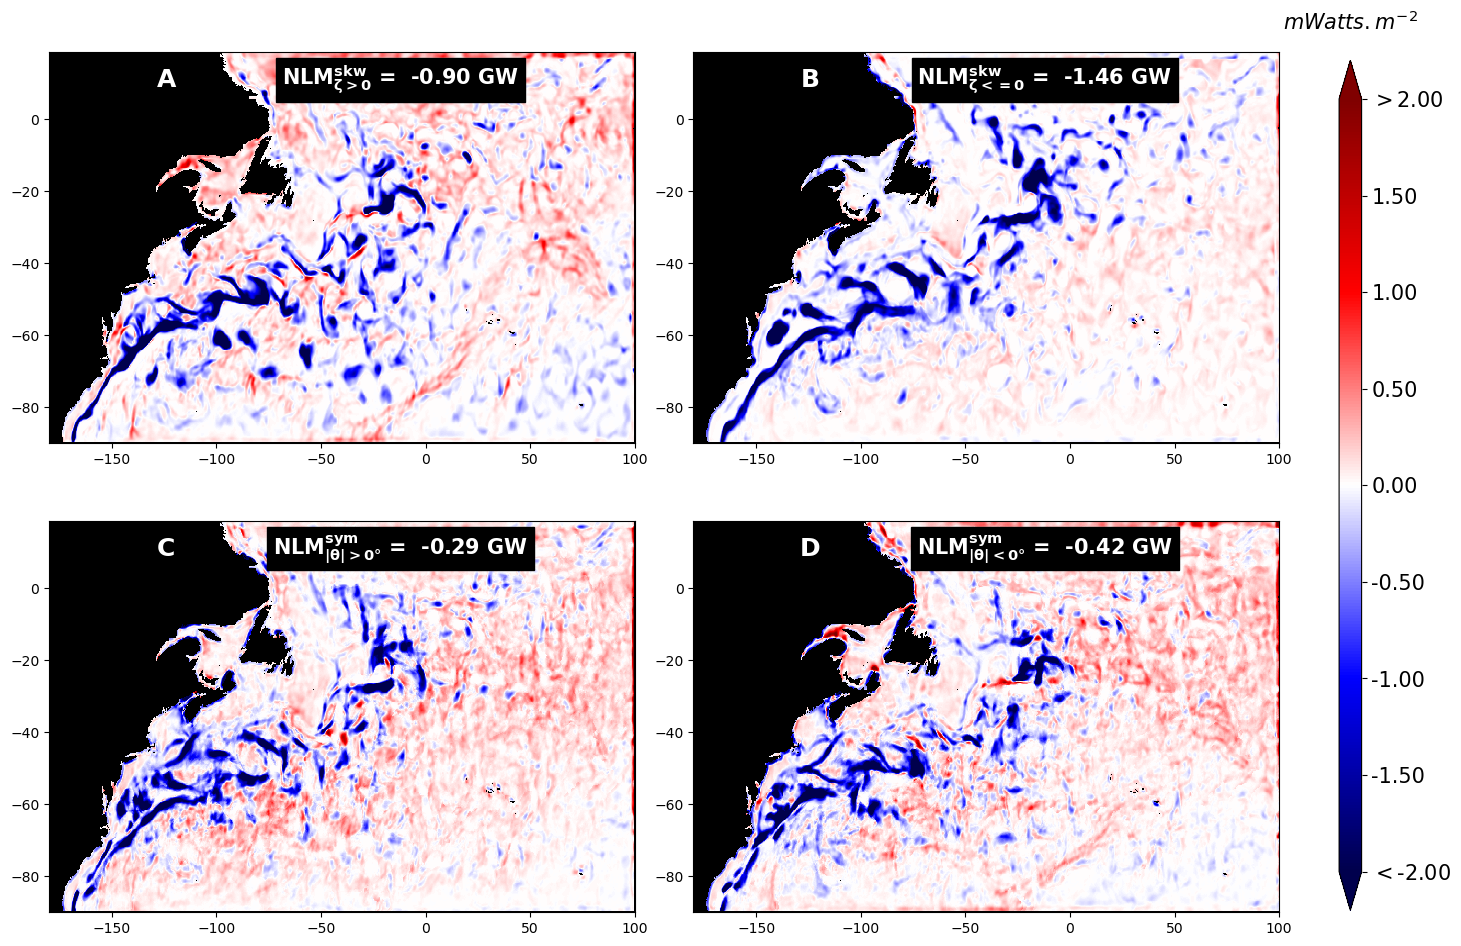

In [27]:
lon = np.arange(0.125,360,0.25)
lat = np.arange(-89.875,90,0.25)

lon[lon>180] -= 360
lon = np.roll(lon, 720)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,10))#, 
                      #subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap1 = plt.get_cmap(cmap_seismic).copy()
cmap1.set_bad('k')

cmap = plt.get_cmap(cmap_seismic).copy()
cmap.set_bad('k')

# y1, y2 = 475, 575
# x1, x2 = 550, 650

y1, y2 = 0, 434
x1, x2 = 0, 1120

X = lon[x1:x2].copy()
Y = lat[y1:y2].copy()

lim = 2

pltArr = posVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{NLM^{skw}_{\zeta > 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(posVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[0, 0], 'A', textInFigColor = 'white',
            writeColorBar = False, projection = False, cf = False)

pltArr = negVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{NLM^{skw}_{\zeta <= 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(negVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[0, 1], 'B', textInFigColor = 'white',
            writeColorBar = False, projection = False, cf = False)

pltArr = posThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{NLM^{sym}_{|\theta| > 0\degree}}$ = '+'{0:6.2f} GW'.format(np.nansum(posThetaNLMstr_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[1, 0], 'C', textInFigColor = 'white',
            writeColorBar = False, projection = False, cf = False)

pltArr = negThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{NLM^{sym}_{|\theta| < 0\degree}}$ = '+'{0:6.2f} GW'.format(np.nansum(negThetaNLMstr_AreaInt)/1e9)
pmesh = plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[1, 1], 'D', textInFigColor = 'white',
            writeColorBar= False, projection = False, cf = False, returnPlot = True)

startx, starty, dx, dy = 0.91, 0.072, 0.015, 0.85
cax = fig.add_axes([startx, starty, dx, dy])
showCommonColorbar(pmesh, cax, lim, '$mWatts.m^{-2}$',greaterThan = True, lessThan = True, padding = 50)

plt.subplots_adjust(left=0.05, right=0.87, bottom=0.07, top = 0.93, wspace=0.1, hspace=0.20)
#plt.savefig('NLM_orientation.pdf', format='pdf', dpi=70)

-12.708543064058063
1.9224581478085976
-10.013362941570923
1.6721153853005073
-3.792604176687454
3.6621238328580588


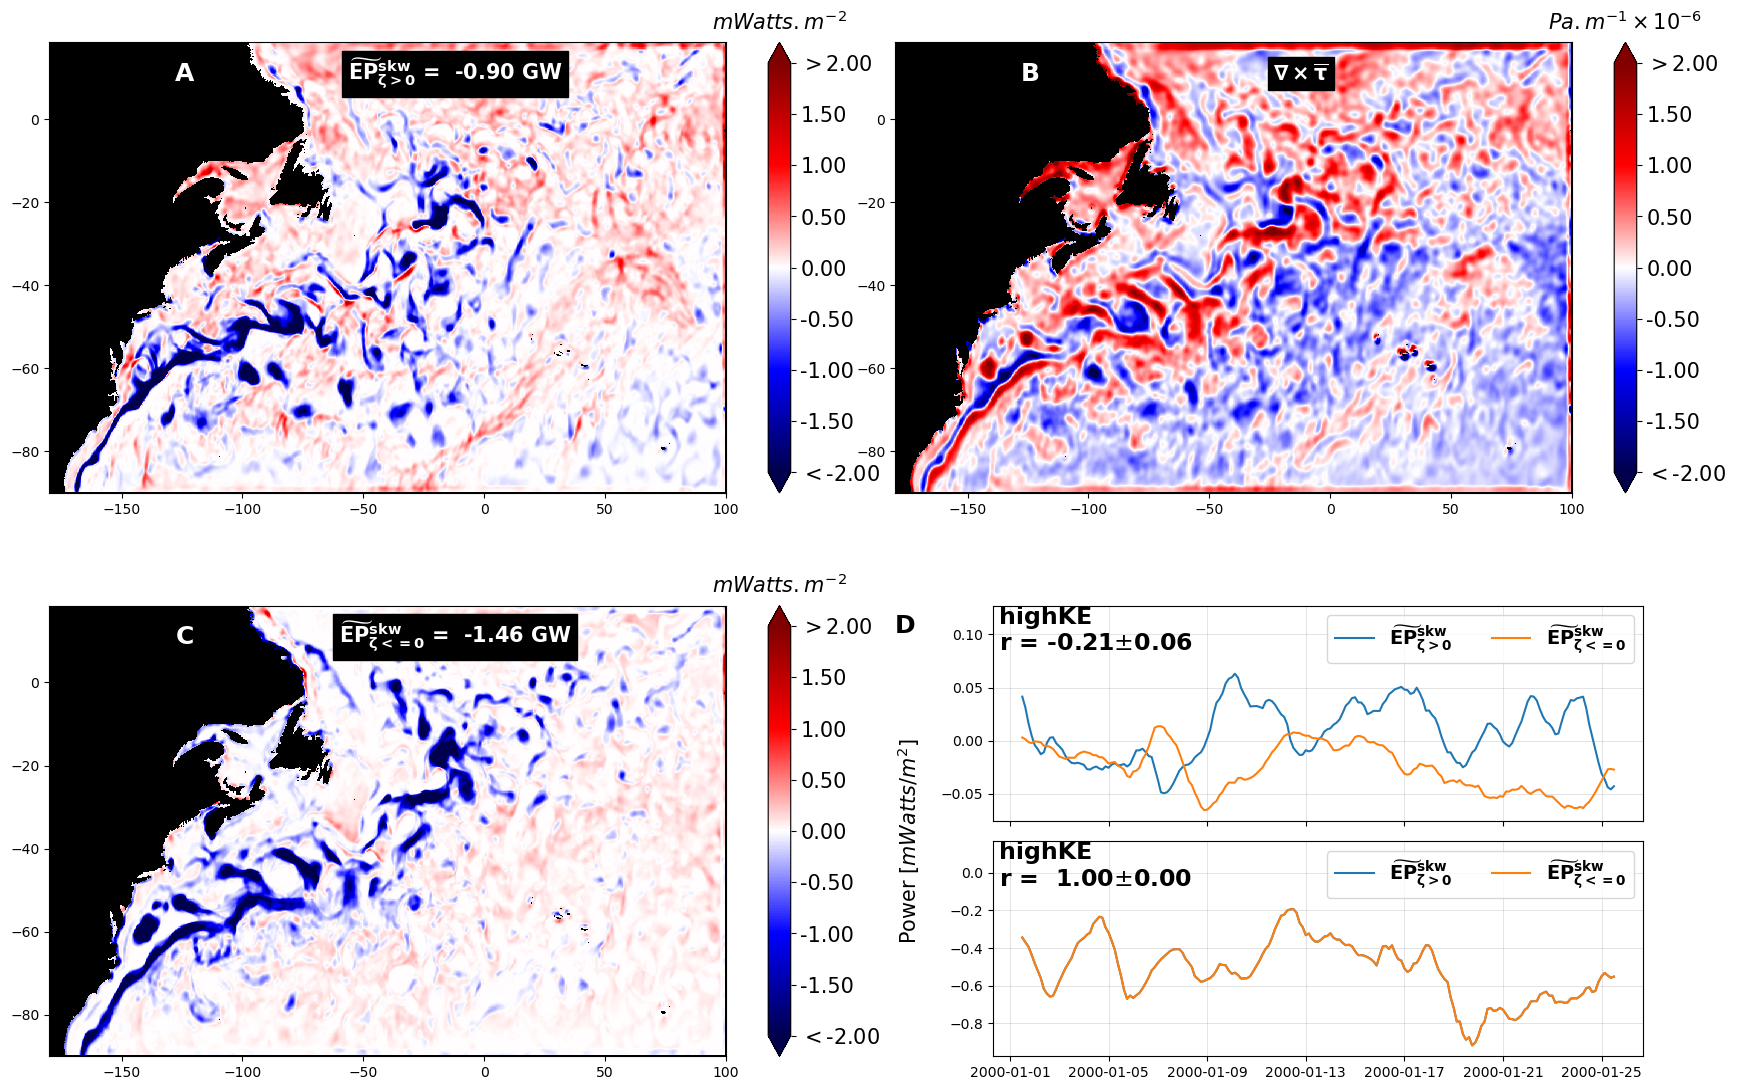

In [28]:
lon = np.arange(0.125,360,0.25)
lat = np.arange(-89.875,90,0.25)

lon[lon>180] -= 360
lon = np.roll(lon, 720)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18,12))
                      #subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap1 = plt.get_cmap(cmap_seismic).copy()
cmap1.set_bad('k')

cmap = plt.get_cmap(cmap_seismic).copy()
cmap.set_bad('k')

# y1, y2 = 475, 575
# x1, x2 = 550, 650

y1, y2 = 0, 434
x1, x2 = 0, 1120

X = lon[x1:x2].copy()
Y = lat[y1:y2].copy()

lim = 2

pltArr = posVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta > 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(posVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[0, 0], 'A', textInFigColor = 'white',
            writeColorBar = True, projection = False, cf = False)

pltArr = negVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta <= 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(negVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[1, 0], 'C', textInFigColor = 'white',
            writeColorBar = True, projection = False, cf = False)

##########################################################

pltArr = curl_stress
text = r'$\mathbf{\nabla\times\overline{\tau}}$'
plot2D_clim(pltArr*1e6, X, Y, text , lim, r'$Pa.m^{-1} \times 10^{-6}$', ax[0,1], 'B', textInFigColor = 'white',
            writeColorBar = True, projection = False, cf = False)

#########################################################

ax[1,1].remove()
ax1 = fig.add_subplot(2, 2, 4)

plot_Trend(dates, vortArr_highKE_TS*1e3, [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<=0}}$'], 
           'highKE', ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, vortArr_lowKE_TS*1e3, [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<=0}}$'], 
           'highKE', axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="15%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'D', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="15%", pad=0.0)
ax0_right.axis('off')

##########################################################

plt.subplots_adjust(left=0.05, right=0.99, bottom=0.085, top = 0.93, wspace=0.0, hspace=0.25)
#plt.savefig('NLM_ZetaOrientation.pdf', format='pdf', dpi=70)

-8.438769412438816
5.348872291917179
-14.627687827722639
2.7247025501288356
-51.45075535722946
48.384231876166716


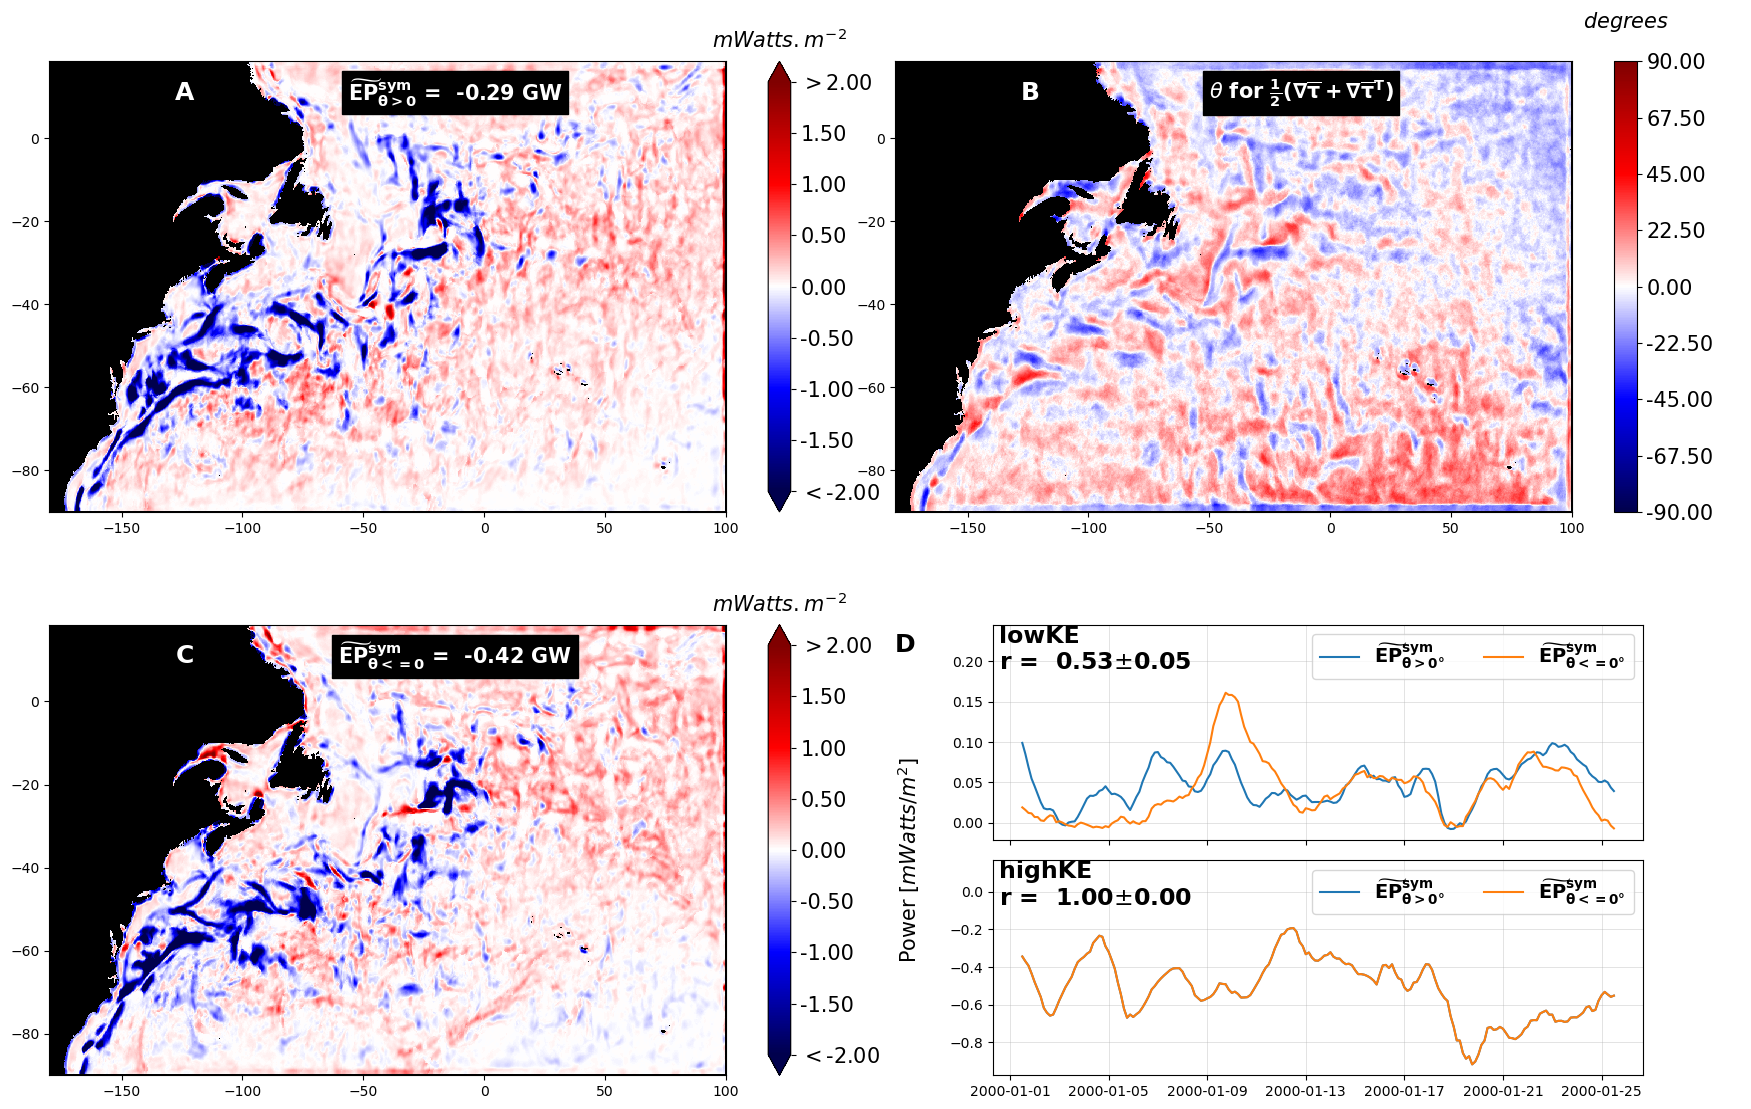

In [29]:
lon = np.arange(0.125,360,0.25)
lat = np.arange(-89.875,90,0.25)

lon[lon>180] -= 360
lon = np.roll(lon, 720)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18,12))
#, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap1 = plt.get_cmap(cmap_seismic).copy()
cmap1.set_bad('k')

cmap = plt.get_cmap(cmap_seismic).copy()
cmap.set_bad('k')

# y1, y2 = 475, 575
# x1, x2 = 550, 650

y1, y2 = 0, 434
x1, x2 = 0, 1120

X = lon[x1:x2].copy()
Y = lat[y1:y2].copy()

lim = 2

pltArr = posThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta > 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(posThetaNLMstr_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[0, 0], 'A', textInFigColor = 'white',
            writeColorBar = True, projection = False, cf = False)

pltArr = negThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta <= 0}}$ = '+'{0:6.2f} GW'.format(np.nansum(negThetaNLMstr_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , lim, '$mWatts.m^{-2}$', ax[1, 0], 'C', textInFigColor = 'white',
            writeColorBar = True, projection = False, cf = False)

##########################################################

pltArr = theta1_tau
lim = 90
text = r'$\theta$ for $\mathbf{\frac{1}{2}(\nabla\overline{\tau} + \nabla\overline{\tau}^{T}) }$'
plot2D_clim(pltArr, X, Y, text , lim, r'$degrees$', ax[0,1], 'B', textInFigColor = 'white',
            greaterThan = False, lessThan = False, writeColorBar = True, projection = False, cf = False)

#########################################################

ax[1,1].remove()
ax1 = fig.add_subplot(2, 2, 4)

plot_Trend(dates, thetaArr_highKE_TS*1e3, [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<=0\degree}}$'], 
           'highKE', ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, thetaArr_lowKE_TS*1e3, [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<=0\degree}}$'], 
           'lowKE', axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="15%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'D', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="15%", pad=0.0)
ax0_right.axis('off')

##########################################################

plt.subplots_adjust(left=0.05, right=0.99, bottom=0.085, top = 0.93, wspace=0.0, hspace=0.25)
#plt.savefig('NLM_StrainOrientation.pdf', format='pdf', dpi=70)

-12.708543064058063
1.9224581478085976


AttributeError: 'GeoAxes' object has no attribute 'background_patch'

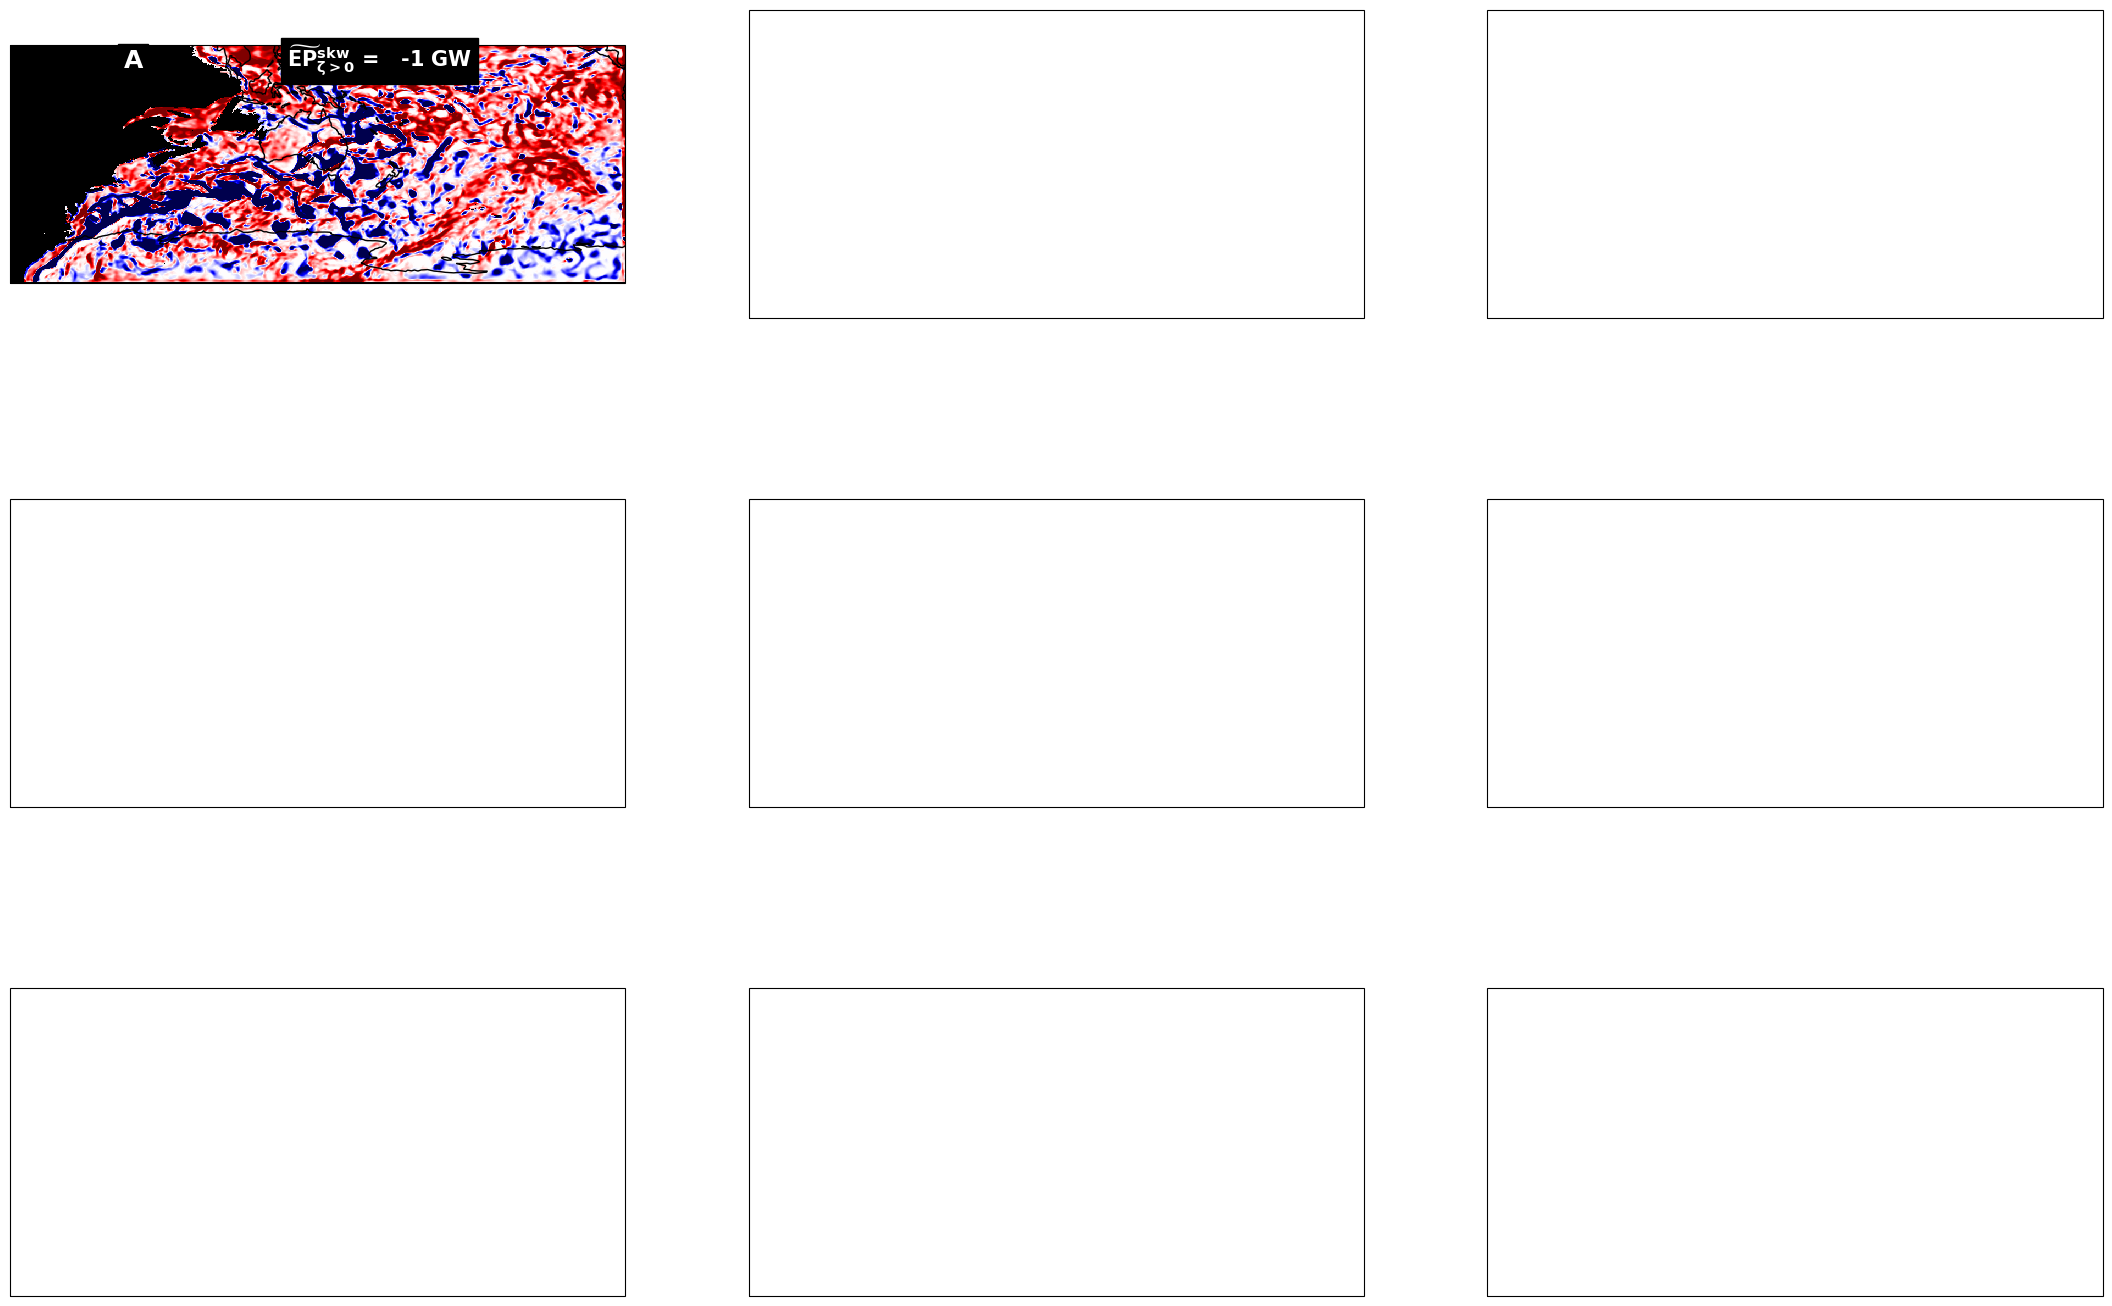

In [30]:
lon = np.arange(0.125,360,0.25)
lat = np.arange(-89.875,90,0.25)

lon[lon>180] -= 360
lon = np.roll(lon, 720)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (27,18),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap1 = plt.get_cmap(cmap_seismic).copy()
cmap1.set_bad('k')

cmap = plt.get_cmap(cmap_seismic).copy()
cmap.set_bad('k')

# y1, y2 = 475, 575
# x1, x2 = 550, 650

y1, y2 = 0, 434
x1, x2 = 0, 1120

X = lon[x1:x2].copy()
Y = lat[y1:y2].copy()

limRow1 = 0.3
curlLim  = 0.3

pltArr = posVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta > 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(posVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , limRow1, '$mWatts.m^{-2}$', ax[0, 0], 
            'A', textInFigColor = 'white',
            topXlabel = True,
            botXlabel = False,
            leftYlabel = True,
            rightYlabel = False,
            writeColorBar = False, projection = True, cf = False)

pltArr = negVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta <= 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(negVortNLMrot_AreaInt)/1e9)
pmesh_top = plot2D_clim(pltArr, X, Y, text , limRow1, '$mWatts.m^{-2}$', ax[0, 1], 
                        'B', textInFigColor = 'white',
                        topXlabel = True,
                        botXlabel = False,
                        leftYlabel = False,
                        rightYlabel = False,
                        returnPlot = True, writeColorBar = False, projection = True, cf = False)

##########################################################

pltArr = curl_stress
text = r'$\mathbf{\nabla\times\overline{\tau}}$'
plot2D_clim(pltArr*1e6, X, Y, text , curlLim, r'$Pa.m^{-1} \times 10^{-6}$', ax[0, 2],
            'C', textInFigColor = 'white',
            topXlabel = True,
            botXlabel = False,
            leftYlabel = False,
            rightYlabel = True,
            writeColorBar = True, projection = True, cf = False)

##########################################################

limRow2 = 0.2

pltArr = posThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta > 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(posThetaNLMstr_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , limRow2, '$mWatts.m^{-2}$', ax[1, 0],
            'D', textInFigColor = 'white',
            topXlabel = False,
            botXlabel = True,
            leftYlabel = True,
            rightYlabel = False,
            writeColorBar = False, projection = True, cf = False)

pltArr = negThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta <= 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(negThetaNLMstr_AreaInt)/1e9)
pmesh_bot = plot2D_clim(pltArr, X, Y, text , limRow2, '$mWatts.m^{-2}$', ax[1, 1], 
                        'E', textInFigColor = 'white',
                        topXlabel = False,
                        botXlabel = True,
                        leftYlabel = False,
                        rightYlabel = False,
                        returnPlot = True, writeColorBar = False, projection = True, cf = False)

##########################################################

pltArr = theta1_tau
lim = 90
text = r'$\theta$ for $\mathbf{\frac{1}{2}(\nabla\overline{\tau} + \nabla\overline{\tau}^{T}) }$'
plot2D_clim(pltArr, X, Y, text , lim, r'$degrees$', ax[1, 2], 
            'F', textInFigColor = 'white',
            topXlabel = False,
            botXlabel = True,
            leftYlabel = False,
            rightYlabel = True,
            greaterThan = False, lessThan = False, writeColorBar = True, projection = True, cf = False)

# #########################################################

ax[2,0].remove()
ax[2,1].remove()
ax[2,2].remove()
ax1 = fig.add_subplot(3, 2, 5)

plot_Trend(dates, vortArr_highKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<=0}}$'], 
           southMaskTitle, ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, vortArr_lowKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<=0}}$'], 
           northMaskTitle, axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="15%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'G', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="15%", pad=0.0)
ax0_right.axis('off')

# #########################################################

ax1 = fig.add_subplot(3, 2, 6)

plot_Trend(dates, strArr_highKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<=0\degree}}$'], 
           southMaskTitle, ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, strArr_lowKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<=0\degree}}$'], 
           northMaskTitle, axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="15%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'H', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="15%", pad=0.0)
ax0_right.axis('off')


# ##########################################################
#######################################

#startx, starty, dx, dy = 0.66, 0.33, 0.015, 0.26
cax = ax[0,0:2] #fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_top, cax, limRow1, '$curl mWatts.m^{-2}$')

# corr = np.corrcoef(x[~np.isnan(x)],y[~np.isnan(y)])[0,1]
# print(corr, corr**2*100)

#######################################

#######################################

#startx, starty, dx, dy = 0.66, 0.66, 0.015, 0.26
cax = cax = ax[1,0:2] #fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_bot, cax, limRow2, '$div mWatts.m^{-2}$')

# corr = np.corrcoef(x[~np.isnan(x)],y[~np.isnan(y)])[0,1]
# print(corr, corr**2*100)

#######################################

plt.subplots_adjust(left=0.05, right=0.99, bottom=0.085, top = 0.93, wspace=0.05, hspace=0.15)
plt.savefig('Merged_4and5.pdf', format='pdf', dpi=70)

In [ ]:
lon = np.arange(0.125,360,0.25)
lat = np.arange(-89.875,90,0.25)

lon[lon>180] -= 360
lon = np.roll(lon, 720)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (18,15),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap1 = plt.get_cmap(cmap_seismic).copy()
cmap1.set_bad('k')

cmap = plt.get_cmap(cmap_seismic).copy()
cmap.set_bad('k')

# y1, y2 = 475, 575
# x1, x2 = 550, 650

y1, y2 = 0, 434
x1, x2 = 0, 1120

X = lon[x1:x2].copy()
Y = lat[y1:y2].copy()

limRow1 = 0.2
curlLim  = 4

pltArr = posVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta > 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(posVortNLMrot_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , limRow1, '$mWatts.m^{-2}$', ax[0, 0], 
            'A', textInFigColor = 'white',
            topXlabel = True,
            botXlabel = False,
            leftYlabel = True,
            rightYlabel = False,
            writeColorBar = False, projection = True, cf = False)

pltArr = negVortNLMrot.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{skw}_{\zeta < 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(negVortNLMrot_AreaInt)/1e9)
pmesh_top = plot2D_clim(pltArr, X, Y, text , limRow1, '$mWatts.m^{-2}$', ax[0, 1], 
                        'B', textInFigColor = 'white',
                        topXlabel = True,
                        botXlabel = False,
                        leftYlabel = False,
                        rightYlabel = False,
                        returnPlot = True, writeColorBar = False, projection = True, cf = False)

##########################################################

pltArr = curl_stress
text = r'$\mathbf{\nabla\times\overline{\tau}}$'
pmesh_curl = plot2D_clim(pltArr*1e7, X, Y, text , curlLim, r'$Pa.m^{-1} \times 10^{-7}$', ax[0, 2],
            'C', textInFigColor = 'white',
            topXlabel = True,
            botXlabel = False,
            leftYlabel = False,
            rightYlabel = True,
            returnPlot = True, writeColorBar = False, projection = True, cf = False)
# ##########################################################

startx, starty, dx, dy = 0.06, 0.68, 0.60, 0.015
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_top, cax, limRow1, '$mWatts.m^{-2}$', orientation='horizontal')

# ##########################################################

startx, starty, dx, dy = 0.70, 0.68, 0.28, 0.015
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_curl, cax, curlLim, r'$Pa.m^{-1} \times 10^{-7}$', 
                   labelFormat = 'int',orientation='horizontal')


##########################################################

limRow2 = 0.2

pltArr = posThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta > 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(posThetaNLMstr_AreaInt)/1e9)
plot2D_clim(pltArr, X, Y, text , limRow2, '$mWatts.m^{-2}$', ax[1, 0],
            'D', textInFigColor = 'white',
            topXlabel = True,
            botXlabel = False,
            leftYlabel = True,
            rightYlabel = False,
            writeColorBar = False, projection = True, cf = False)

pltArr = negThetaNLMstr.copy() * 1e3
#pltArr4[landMask] = float('nan')
# vval =  np.nansum(avgNLmodel_strain[:, :] * UAREA)/1e9
text = r'$\mathbf{\widetilde{EP}^{sym}_{\theta < 0}}$ = '+'{0:4.0f} GW'.format(np.nansum(negThetaNLMstr_AreaInt)/1e9)
pmesh_bot = plot2D_clim(pltArr, X, Y, text , limRow2, '$mWatts.m^{-2}$', ax[1, 1], 
                        'E', textInFigColor = 'white',
                        topXlabel = True,
                        botXlabel = False,
                        leftYlabel = False,
                        rightYlabel = False,
                        returnPlot = True, writeColorBar = False, projection = True, cf = False)

##########################################################

pltArr = theta1_tau
text = r'$\theta$ for $\mathbf{\frac{1}{2}(\nabla\overline{\tau} + \nabla\overline{\tau}^{T}) }$'
pmesh_symTau = plot2D_clim(pltArr, X, Y, text , lim, r'$degrees$', ax[1, 2], 
                            'F', textInFigColor = 'white',
                            topXlabel = True,
                            botXlabel = False,
                            leftYlabel = False,
                            rightYlabel = True,
                            returnPlot = True,
                            greaterThan = False, 
                            lessThan = False, 
                            writeColorBar = False, projection = True, cf = False)


# ##########################################################

startx, starty, dx, dy = 0.06, 0.37, 0.60, 0.015
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_bot, cax, limRow2, '$mWatts.m^{-2}$', orientation='horizontal')

# ##########################################################

startx, starty, dx, dy = 0.70, 0.37, 0.28, 0.015
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(pmesh_symTau, cax, 90, r'$degrees$', 
                   labelFormat = 'int', greaterThan = False, lessThan = False, orientation='horizontal')

# #########################################################


ax[2,0].remove()
ax[2,1].remove()
ax[2,2].remove()
ax1 = fig.add_subplot(3, 2, 5)

plot_Trend(dates, vortArr_highKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<0}}$'], 
           southMaskTitle, ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, vortArr_lowKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{skw}_{\zeta>0}}$',r'$\mathbf{\widetilde{EP}^{skw}_{\zeta<0}}$'], 
           northMaskTitle, axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="13%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'G', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="10%", pad=0.0)
ax0_right.axis('off')

# #########################################################

ax1 = fig.add_subplot(3, 2, 6)

plot_Trend(dates, strArr_highKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<0\degree}}$'], 
           southMaskTitle, ax1)#, showXticks=False )

divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(dates, strArr_lowKE_TS*1e3, 
           [r'$\mathbf{\widetilde{EP}^{sym}_{\theta>0\degree}}$',r'$\mathbf{\widetilde{EP}^{sym}_{\theta<0\degree}}$'], 
           northMaskTitle, axB, showXticks=False )

# axC = divider.append_axes("top", size="8%", pad=0.2)
# handles, labels = axB.get_legend_handles_labels()
# axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

# axC.axis('off')

ax0 = divider.append_axes("left", size="13%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'H', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

ax0_right = divider.append_axes("right", size="10%", pad=0.0)
ax0_right.axis('off')

#######################################

#######################################

#startx, starty, dx, dy = 0.66, 0.66, 0.015, 0.26
#cax = cax = ax[1,0:2] #fig.add_axes([startx, starty, dx, dy]) 
#showCommonColorbar(pmesh_bot, cax, limRow2, '$div mWatts.m^{-2}$')

# corr = np.corrcoef(x[~np.isnan(x)],y[~np.isnan(y)])[0,1]
# print(corr, corr**2*100)

#######################################

plt.subplots_adjust(left=0.05, right=0.99, bottom=0.085, top = 0.93, wspace=0.05, hspace=0.38)
plt.savefig('Merged_4and5.pdf', format='pdf', dpi=70)